# MICCoM School 2017 Ex#1 : The VIP of SiH<sub>4</sub>

We are going to compute the Vertical Ionization Potential (VIP) of the silane molecule using DFT@PBE and GW.

The VIP is the minimum amount of energy that is needed in order to remove an electron from a molecule. When the removal does not take into account ion relaxation processes (change of molecular geometry), the ionization is said to be *vertical*.

The experimental value for the VIP of silane is tabulated in the NIST chemistry webbook: http://webbook.nist.gov/chemistry/form-ser/.

<p><center><b>VIP of silane = $12.3\, eV$ (experimental value)</b></center></p>
<p>~<i>We would like to compute the VIP of silane from first principles using DFT and GW.</i>~ </p>

Let's see which level of theory performs better.

## 1.1 : DFT calculation

We are going to numerically solve the Kohn-Sham equations for valence electrons only. Electronic wavefunctions and single particle energies are obtained by solving the secular equation:

\begin{equation}
H^{KS}[\rho] \, \psi_n = \varepsilon_n^{KS} \psi_n
\end{equation}

The Hamiltonian of $N$ interacting electrons is formed by the following terms:

\begin{equation}
H^{KS}[\rho] = T + V_{ion} + V_{Hartree}[\rho] + V_{xc}[\rho] 
\end{equation}

where $T$ is the kinetic energy, $V_{ion}$ is the electron-ion potential, $V_{Hartree}$ is the Hartree potential, and $V_{xc}$ is the exchange-correlation potential.

Note that the secular equation needs to be solved self-consistenly since the operator that we are diagonalizing depends on the eigenvectors ($\rho = \sum_n |\psi_n|^2$).

In this implemenation of DFT we are going to use plane-waves as basis set. This means that an electronic wavefunction $\psi_n$ is obtained by computing the coefficients $C_n$ of the plane-waves expansion: 

\begin{equation}
\psi_n(\mathbf{r}) = \sum_{\mathbf{G}} C_n(\mathbf{G}) e^{i\mathbf{G}\cdot\mathbf{r}}
\end{equation}

In this way the kinetic energy of an electronic wavefunction will be obtained as $\sum_{\mathbf{G}} \left| C_n(\mathbf{G}) \right|^2 G^2$. The total number of plane-waves is determined once we specify the size of the simulation box and the kinetic energy cutoff.

The electron-ion potetial $V_{ion}$ is solved separately for each given atomic species. Pseudopotential files contain this information (previously computed) are typically loaded at the beginning of the calculation. Pseudopotentials can be downloaded from several websites, for instance: 

<ul>
<li>SG15 : http://www.quantum-simulation.org/potentials/sg15_oncv/
<li>Quantum ESPRESSO : https://www.quantum-espresso.org/pseudopotentials/
</ul> 

Note that we will be using only Norm-Conserving pseudopotentials (i.e., no Ultrasoft or PAW).

The Hartree potential is determined self-consistely as $V_{Hartree}(\mathbf{r}) = \int d\mathbf{r^\prime} \rho(\mathbf{r^\prime}) \frac{1}{|\mathbf{r}-\mathbf{r^\prime}|}$. 

The exact form for the exchange and correlation potential is unknown, many approximations are available. The user needs to make this decision. 

If we interpret $\varepsilon^{KS}_n$ as electronic excitation energies (which is physically incorrect but people still do this as an approximation), the VIP will simply be the energy of the highest occupied molecular orbital (HOMO) obtained in a DFT calculation. 

\begin{equation}
VIP^{DFT} = 0 - \varepsilon^{KS}_{HOMO}
\end{equation}

</p>
<p><b>Question</b>: <i>Where did the core electrons go?</i></p>
<p><b>Question</b>: <i>How many valence electrons do we have in SiH<sub>4</sub>?</i></p> 
<p><b>Question</b>: <i>Plane-waves satisfy periodic boundary conditions, how can we simulate an isolated molecule?</i></p> 

The following files are needed in order to compute the electronic structure of SiH<sub>4</sub> with DFT:

- `Si_ONCV_PBE-1.2.upf` : pseudopotential file for Si
- `H_ONCV_PBE-1.2.upf` : pseudopotential file for H
- `pw.in` : input file for the DFT calculation (executable : `pw.x`)

In [ ]:
#download the material

#pseudopotential files
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf

#input file    
!wget -N -q http://www.west-code.org/doc/training/silane/pw.in

Let's give a quick look at the input for DFT (description of the input variables for `pw.x` can be found here: https://www.quantum-espresso.org/Doc/INPUT_PW.html)

In [ ]:
!cat pw.in

<p>We have placed the silane molecule in a cubic box (edge = 20 bohr), and selected a kinetic energy cutoff of 25 Ry. </p>

We can run the DFT calculation invoking the executable `pw.x` on 8 cores.

In [ ]:
!mpirun -n 8 pw.x -i pw.in > pw.out

The highest occupied molecular orbital (HOMO) predicted by DFT is located at $-8.2314\,eV$.

The lowest unoccupied molecular orbital (LUMO) predicted by DFT is located at $-0.4659\,eV$.

Let's plot this result.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# VIP 
y = {}
y['exp'] = [12.3]     # experimental 
y['dft'] = [8.2314]   # DFT 

#colors of the plot 
c = {}
c['exp'] = 'black' 
c['dft'] = 'red'

# plot 
x = list( range( 1, len(y)+1 ) )
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
    for a in y[i] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[i])
    counter += 1

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')

plt.title('VIP')

plt.show()

**Question**: *Is this level of agreement ok?*

## 1.2 : GW calculation
Using Many-Body Perturbation Theory (MBPT) can improve the result of DFT by computing single particle excitations as the eigenvalues of the quasiparticle (QP) Hamiltonian:

\begin{equation}
H^{QP}[\rho] = T + V_{ion} + V_{Hartree}[\rho] + \Sigma
\end{equation}

Note that $H^{QP}$ can be obtained from $H^{KS}$ by replacing the exchange and correlation potential with the self-energy $\Sigma$. In the GW approximation the electron self-energy can be written as : 

\begin{equation}
\Sigma(\mathbf{r},\mathbf{r^\prime};E)  = i \int \frac{d\omega}{2\pi} G(\mathbf{r},\mathbf{r^\prime};E-\omega) W(\mathbf{r},\mathbf{r^\prime};\omega)
\end{equation}

$G$ is the Green's function and $W=\epsilon^{-1}v$ is the screened Coulomb potential. Because both $G$ and $W$ depend self-consistently on the solution of the QP Hamiltonian, typically the eigenvalues of the operator of $H^{QP}$ are obtained using the eigenvalues and eigenvectors of $H^{KS}$ (computed previously in DFT) and using first order perturbation theory: 

\begin{equation}
E^{QP}_n = \varepsilon^{KS}_n + \left\langle \psi_n \right | \Sigma(E^{QP}_n) - V_{xc}\left| \psi_n \right\rangle
\end{equation}

Following the workflow discussed in <a href="https://pubs.acs.org/doi/full/10.1021/ct500958p#showFigures">J. Chem. Theory Comput. 11, 2680 (2015)</a> we use the DFT output to: 
<img src="https://pubs.acs.org/cms/10.1021/ct500958p/asset/images/medium/ct-2014-00958p_0015.gif" width="50%">

- compute the Projective Dielectric EigendecomPosition (PDEP) : executable `wstat.x`
- compute the GW electronic structure : executable `wfreq.x`

In this case we will have:

\begin{equation}
VIP^{GW} = 0 - E^{QP}_{HOMO}
\end{equation}

In [ ]:
#download the material

#input file    
!wget -N -q http://www.west-code.org/doc/training/silane/wstat.in
!wget -N -q http://www.west-code.org/doc/training/silane/wfreq.in

Let's give a quick look at the input for `wstat.x` (description of the input variables for `wstat.x` can be found here: http://www.west-code.org/doc/West/latest/manual.html#wstat-control)

In [ ]:
!cat wstat.in

The variable `silane` instructs the code to find the output of DFT in the folder `silane.save`. We are going to compute 50 eigenpotentials.

<p>We can run the PDEP calculation invoking the executable `wstat.x` on 8 cores.

In [ ]:
!mpirun -n 8 wstat.x -i wstat.in > wstat.out

Now we compute G, W and solve the GW electronic structure. Let's give a quick look at the input for `wfreq.x` (description of the input variables for `wfreq.x` can be found here: http://www.west-code.org/doc/West/latest/manual.html#wfreq-control)

In [ ]:
!cat wfreq.in

We are going to compute the GW energy of the states 1, 2, 3, 4 (HOMO), and 5 (LUMO). Remember that in this example each state can host two electrons.

We can run the GW calculation invoking the executable `wfreq.x` on 8 cores.

In [ ]:
!mpirun -n 8 wfreq.x -i wfreq.in > wfreq.out

The highest occupied molecular orbital (HOMO) predicted by GW is located at $-12.044023\,eV$.

Let's update the plot shown before.

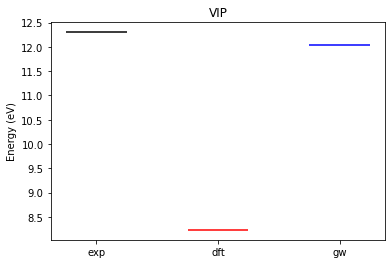

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# VIP 
y = {}
y['exp'] = [12.3]      # experimental 
y['dft'] = [8.2314]    # dft
y['gw']  = [12.044023] # gw

# colors 
c = {}
c['exp'] = 'black'
c['dft'] = 'red'
c['gw']  = 'blue'

# plot 
x = list( range( 1, len(y)+1 ) )
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
   for a in y[i] :
      ax.hlines(a, x[counter]-0.25, x[counter]+0.25,color=c[i])
   counter += 1

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')

plt.title('VIP')

plt.show()

If we take into account finite size effects we have:

\begin{equation}
VIP^{GW} = E_{vacuum} - E^{QP}_{HOMO}
\end{equation}


The vaccum energy is $0.24574632 \, eV$. Let's update the plot.

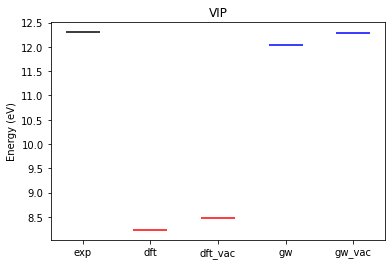

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# vacumm 
vacuum = 0.24574632

# VIP 
y = {}
y['exp']     = [12.3]             # experimental
y['dft']     = [8.2314]           # dft
y['dft_vac'] = [8.2314+vacuum]    # dft
y['gw']      = [12.044023]        # gw
y['gw_vac']  = [12.044023+vacuum] # gw

# colors 
c = {}
c['exp']     = 'black'
c['dft']     = 'red'
c['dft_vac'] = 'red'
c['gw']      = 'blue'
c['gw_vac']  = 'blue'

# plot 
x = list( range( 1, len(y)+1 ) )
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
    for a in y[i] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[i])
    counter += 1

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')

plt.title('VIP')

plt.show()

**Question**: *Which level of theory better describes electronic excitations?*